# PyTorch: Linear regression to non linear probabilistic neural network
This post follows a similar one I did a while back for Tensorflow Probability.
I will go various models from linear regression through to a non-linear probabilistic neural network.

This is particularly useful in case where the model noise changes with one of the model variables or is non-linear,
such as in those with heteroskedasticity.

Inspiration to try this on PyTorch distribution was from here:
[https://github.com/srom/distributions](https://github.com/srom/distributions)

Import stuff:

In [1]:
import numpy as np
import pandas as pd

import torch
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

Let's generate some data with non-linearities that would pose some issues for a linear regression solution:

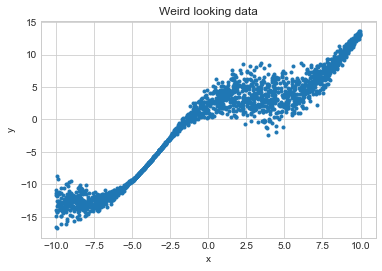

In [2]:
# amount of noise that is added is a function of x
n = 2000
x = np.random.uniform(-10, 10, size=n)
noise_std = np.sin(x * 0.4) + 1
y = -0.5 + 1.3 * x + 3 * np.cos(x * 0.5) + np.random.normal(loc=0, scale=noise_std)

x_train = x[: n // 2]
x_test = x[n // 2 :]
y_train = y[: n // 2]
y_test = y[n // 2 :]

plt.plot(x, y, ".")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Weird looking data")
plt.show()

Next we prep data for PyTorch by converting to Tensors and
creating dataloaders to sort of training batches for us.

In [3]:
from torch.utils.data import TensorDataset, DataLoader

x_train_t = torch.Tensor(x_train[:, np.newaxis])
y_train_t = torch.Tensor(y_train[:, np.newaxis])
x_test_t = torch.Tensor(x_test[:, np.newaxis])
y_test_t = torch.Tensor(y_test[:, np.newaxis])

dataset_train = TensorDataset(x_train_t, y_train_t)
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataset_test = TensorDataset(x_test_t, y_test_t)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)

Next we define various helper functions to help train our models:

In [4]:
def loss_fn_loglike(y_hat, y):
    negloglik = -y_hat.log_prob(y)
    return torch.mean(negloglik)


def train_loop(x, y, model, loss_fn, optimizer):
    # Compute prediction and loss
    y_hat = model(x)
    loss = loss_fn(y_hat, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


def test_loop(x, y, model, loss_fn):
    with torch.no_grad():
        y_hat = model(x)
        test_loss = loss_fn(y_hat, y).item()

    return test_loss


def train_loop_dl(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
        loss = train_loop(x, y, model, loss_fn, optimizer)
    return loss


def test_loop_dl(dataloader, model, loss_fn):
    size = len(dataloader_train.dataset)
    test_loss = 0

    for x, y in dataloader:
        _test_loss = test_loop(x, y, model, loss_fn)
        test_loss += _test_loss * len(x)

    test_loss /= size
    return test_loss


def train_dl(model, dataloader_train, dataloader_test, loss_fn, optimizer, epochs=20):
    loss_train = []
    loss_test = []
    for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        train_loop_dl(dataloader_train, model, loss_fn, optimizer)
        loss_train.append(test_loop_dl(dataloader_train, model, loss_fn))
        loss_test.append(test_loop_dl(dataloader_test, model, loss_fn))
        # if t+1 % 5 == 0:
        #     print(
        #         f"Epoch {t+1}, train loss: {loss_train[-1]:>7f}, test loss: {loss_test[-1]:>7f}"
        #     )
    return loss_train, loss_test


def train(
    model,
    x_train_t,
    y_train_t,
    x_test_t,
    y_test_t,
    loss_fn,
    optimizer,
    epochs=100,
):
    loss_train = []
    loss_test = []
    for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        loss = train_loop(x_train_t, y_train_t, model, loss_fn, optimizer)
        loss_train.append(test_loop(x_train_t, y_train_t, model, loss_fn))
        loss_test.append(test_loop(x_test_t, y_test_t, model, loss_fn))
        # print(
        #     f"train loss: {loss_train[-1]:>7f}, test loss: {loss_test[-1]:>7f}"
        # )
    return loss_train, loss_test


def plot_loss(loss_train, loss_test):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(np.array(loss_train), label="Train loss")
    ax.plot(np.array(loss_test), label="Test loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("NegLogLike")
    ax.set_title("Training Overview")
    ax.legend()

    plt.show()


def plot_results(x, y, y_est_mu, y_est_std=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, ".", label="y")
    plt.plot(x, y_est_mu, "-y", label="y_est_mu")
    if y_est_std is not None:
        plt.plot(x, y_est_mu + 2 * y_est_std, "-r", label="mu+2std")
        plt.plot(x, y_est_mu - 2 * y_est_std, "-r", label="mu-2std")
    plt.legend()
    plt.show()


def plot_model_results(model, x, y):
    si = np.argsort(x)
    x = x[si]
    y = y[si]
    y_hat = model(torch.Tensor(x[:, np.newaxis]))
    y_est_mu = y_hat.mean.detach().numpy()
    y_est_std = y_hat.scale.detach().numpy()
    plot_results(x, y, y_est_mu, y_est_std)

## Linear regression approach
We can fit a linear regression model using PyTorch.
This model would have no hidden layers, so the output can only be a linear weighted sum of the input and a bias.
We optimise for the mean squared error, which is the standard loss function for linear regression.

In [5]:
class LinearModel(torch.nn.Module):
    def __init__(self, n_inputs: int = 1, scale: float = 1):
        super().__init__()
        self.output_layer = torch.nn.Linear(n_inputs, 1)
        self.scale = scale

    def forward(self, x):
        output_mean = self.output_layer(x)
        return torch.distributions.Normal(
            output_mean, torch.Tensor().new_full(x.shape, self.scale)
        )

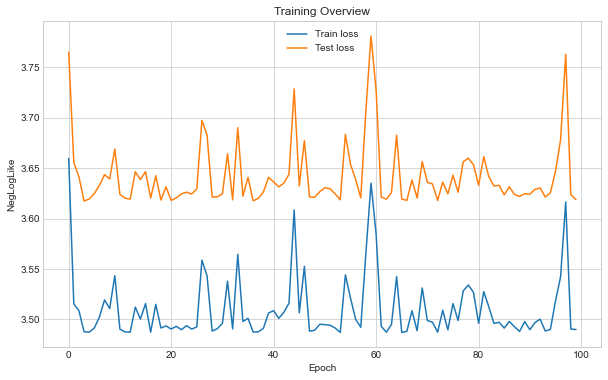

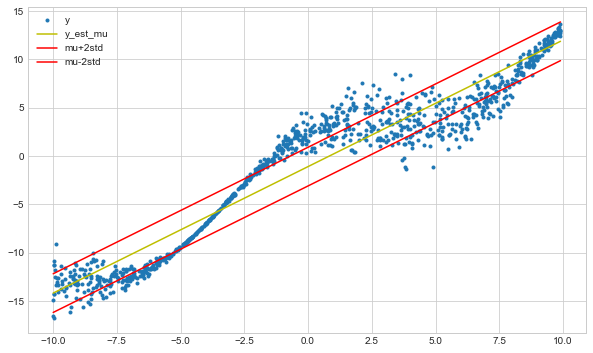

In [6]:
model_lm = LinearModel(1)

learning_rate = 0.1
optimizer = torch.optim.Adam(model_lm.parameters(), lr=learning_rate)

loss_train, loss_test = train_dl(
    model_lm,
    dataloader_train,
    dataloader_test,
    loss_fn_loglike,
    optimizer,
    epochs=100,
)

plot_loss(loss_train, loss_test)
plot_model_results(model_lm, x_train, y_train)

## Linear regression with standard deviation
Using PyTorch distributions we can fit an output layer whilst both considering the mean and standard deviation.
We use an additional parameter to set a trainable static standard deviation.

In [7]:
class LinearModelScale(torch.nn.Module):
    def __init__(self, n_inputs: int = 1):
        super().__init__()
        self.mean_layer = torch.nn.Linear(n_inputs, 1)
        self.s = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        output_mean = self.mean_layer(x)
        output_scale = torch.nn.functional.softplus(self.s)

        return torch.distributions.Normal(output_mean, output_scale)

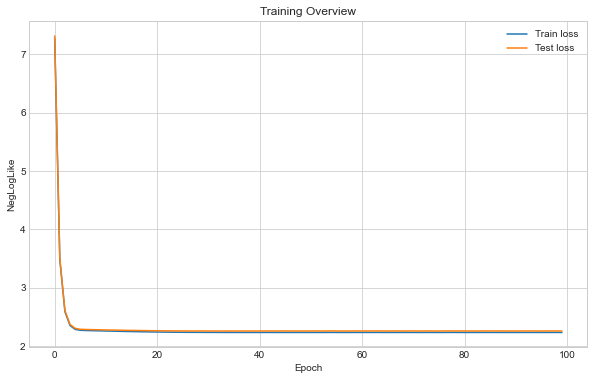

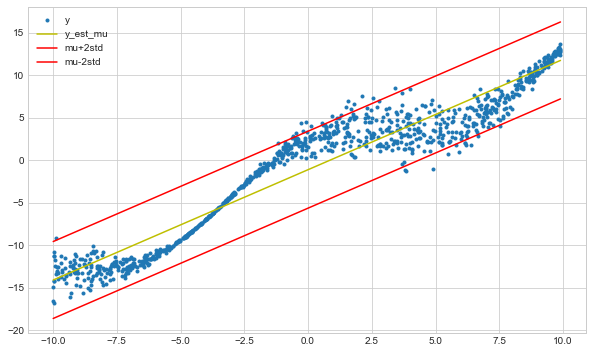

In [8]:
model_lms = LinearModelScale(1)

learning_rate = 0.05
optimizer = torch.optim.Adam(model_lms.parameters(), lr=learning_rate)

loss_train, loss_test = train_dl(
    model_lms,
    dataloader_train,
    dataloader_test,
    loss_fn_loglike,
    optimizer,
    epochs=100,
)

plot_loss(loss_train, loss_test)
plot_model_results(model_lms, x_train, y_train)

The standard deviation captures the uncertainty of our data better than before.

## Probabilistic Neural Network
By adding in hidden layers we can capture the non-linear relationship.
This can be applied to both the mean and standard deivation.
As such the modelled standard deviation can vary with `x`.

In [9]:
class DeepNormalModel(torch.nn.Module):
    def __init__(self, n_inputs: int = 1, n_hidden: int = 10):
        super().__init__()

        self.hidden = torch.nn.Linear(n_inputs, n_hidden)
        self.mean_linear = torch.nn.Linear(n_hidden, 1)
        self.scale_linear = torch.nn.Linear(n_hidden, 1)

    def forward(self, x):
        outputs = self.hidden(x)
        # outputs = torch.relu(outputs)
        outputs = torch.sigmoid(outputs)

        mean = self.mean_linear(outputs)
        scale = torch.nn.functional.softplus(self.scale_linear(outputs))

        return torch.distributions.Normal(mean, scale)

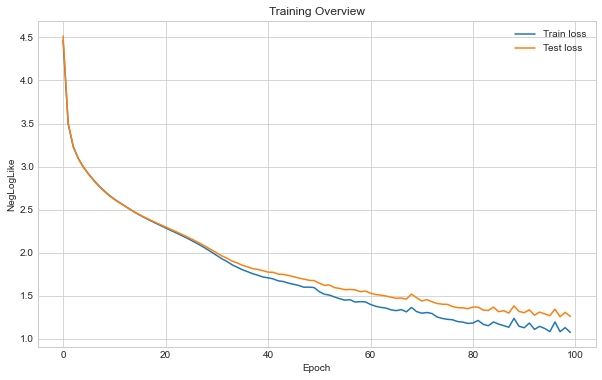

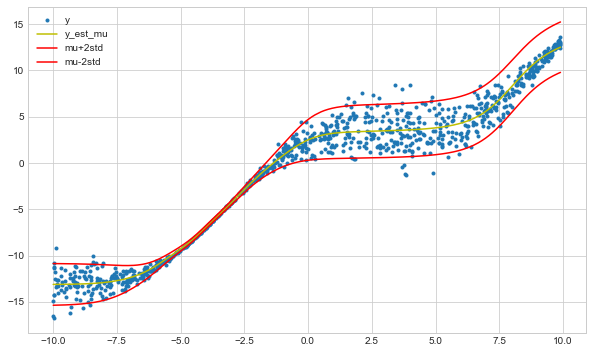

In [10]:
model_dnm = DeepNormalModel(1)

learning_rate = 0.05
optimizer = torch.optim.Adam(model_dnm.parameters(), lr=learning_rate)

loss_train, loss_test = train_dl(
    model_dnm,
    dataloader_train,
    dataloader_test,
    loss_fn_loglike,
    optimizer,
    epochs=100,
)

plot_loss(loss_train, loss_test)
plot_model_results(model_dnm, x_train, y_train)

Clearly the neural network approach significantly better captures the data trends.
Inspect the loglikelihood of each model shows this well (lower is better):

In [11]:
results = pd.DataFrame(index=["Train", "Test"])

models = {
    "Linear regression": model_lm,
    "Linear regression + scale": model_lms,
    "Neural network + scale": model_dnm,
}
for model in models:
    results[model] = [
        loss_fn_loglike(models[model](x_train_t), y_train_t).item(),
        loss_fn_loglike(models[model](x_test_t), y_test_t).item(),
    ]
results.transpose()

,Train,Test
Linear regression,3.489965,3.618836
Linear regression + scale,2.237137,2.262738
Neural network + scale,1.073137,1.259651
